In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/cs444-final-project/project/data/small_data/train.zip


In [ ]:
!unzip /content/drive/MyDrive/cs444-final-project/project/data/small_data/test.zip


In [ ]:
LOG_FILE = '/content/drive/MyDrive/cs444-final-project/project/models/baselines/train_logs/ablation_resnet-18.log'
MODEL_SAVE_TO = '/content/drive/MyDrive/cs444-final-project/project/models/baselines/saved_models/ablation_resnet-18.pth'

In [ ]:
from torchvision import datasets, models, transforms
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class LandmarkImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, id_path_mapping="", is_pt=False):
        """
        Args:
            annotations_file (string): Path to the CSV file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            file_extension (string, optional): Extension of the image files in the directory.
        """
        self.img_labels = pd.read_csv(annotations_file)
        self.id_to_label = {str(row[0]): row[3] for row in self.img_labels.values}
        self.transform = transform
        self.id_path_mapping = pd.read_csv(id_path_mapping)
        self.length = len(self.id_path_mapping)
        self.is_pt = is_pt


    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Retrieve the image ID and path from the mapping
        image_id = self.id_path_mapping.iloc[idx]['id']
        image_path = self.id_path_mapping.iloc[idx]['path']

        label = self.id_to_label[str(image_id)]

        if self.is_pt:
            tensor = torch.load(image_path)
            if self.transform:
                tensor = self.transform(tensor)
            return tensor, label
        else:
            # Load the image
            image = Image.open(image_path)
            # Apply transform if any
            if self.transform:
                image = self.transform(image)
            return image, label


# Define transformations for the training data
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform_pt = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

label_csv = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/small_data.csv"
# train_img_id_to_path_mapping = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/train_img_id_to_path_mapping.csv"
train_img_id_to_path_mapping = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/train_img_id_to_path_mapping_drive.csv" # "/content/drive/MyDrive/cs444-final-project/project/data/small_data/train_pt_id_to_path_mapping.csv"
# Create an instance of the dataset
train_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=train_img_id_to_path_mapping,
    # is_pt=True
    is_pt=False
)

# Define the DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=2)



In [ ]:
len(train_dataset)

6731

# Metrics

In [ ]:
class RunningAverage:
    '''
      Computes and keeps track of the running average and the current value of metrics
    '''
    def __init__(self) -> None:
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0

    def update(self, val: float, n: int = 1) -> None:
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def GAP(predicts: torch.Tensor, confs: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Calculates the simplified Global Average Precision.
    https://www.kaggle.com/competitions/landmark-recognition-2020/overview/evaluation

    Args:
        predicts (torch.Tensor): Predicted labels of shape (n_samples,).
        confs (torch.Tensor): Confidence scores associated with predictions, of shape (n_samples,).
        targets (torch.Tensor): Ground truth labels, of shape (n_samples,).

    Returns:
        float: The GAP score for the given predictions and targets.
    """
    assert len(predicts.shape) == 1 and len(confs.shape) == 1 and len(targets.shape) == 1 and predicts.shape == confs.shape and confs.shape == targets.shape

    _, indices = torch.sort(confs, descending=True)

    confs = confs.cpu().numpy()
    predicts = predicts[indices].cpu().numpy()
    targets = targets[indices].cpu().numpy()

    res, true_pos = 0.0, 0

    for i, (c, p, t) in enumerate(zip(confs, predicts, targets)):
        rel = int(p == t)
        true_pos += rel

        res += true_pos / (i + 1) * rel

    res /= targets.shape[0]
    return res

# Model Initialization

In [ ]:
from torchvision import models
import torch

def initialize_model(num_classes):
    # Load a pretrained ResNet-18 model
    model = models.resnet18(pretrained=True)
    # Modify the final layer to match the number of classes
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, num_classes)
    return model

# Determine the number of unique classes
num_classes = len(set(train_dataset.id_to_label.values()))

# num_classes=2000
print(f"number of classes {num_classes}")
model = initialize_model(num_classes=num_classes)



number of classes 25


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


# Model Finetuning

In [ ]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

def train_model(model, train_loader, loss_fn, optimizer, device, epochs=10):
    model.to(device)
    train_losses = []
    train_accuracies = []
    train_gap = []
    best_train_loss = float('inf')
    best_score = float('-inf')
    for epoch in range(epochs):
        model.train()
        avg_score = RunningAverage()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Wrap the training loop with tqdm for a progress bar
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=True)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            confs, predicts = torch.max(outputs.detach(), dim=1)
            avg_score.update(GAP(predicts, confs, labels))

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            # Update the progress bar with current loss and accuracy
            progress_bar.set_postfix(loss=f'{running_loss / total_samples:.4f}', acc=f'{(correct_predictions.double() / total_samples * 100):.2f}%', gap=f'{avg_score.avg:.4f}')

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_predictions.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        train_gap.append(avg_score.avg)


        # Save the best model if the training loss has improved
        if epoch_loss < best_train_loss and avg_score.avg > best_score:
            best_score = avg_score.avg
            best_train_loss = epoch_loss
            torch.save(model.state_dict(), MODEL_SAVE_TO)
            print(f'Saved best model with Train Loss: {epoch_loss}, GAP score: {round(best_score, 4)}')

    return train_losses, train_gap, train_accuracies



In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies):
    plt.figure(figsize=(10, 5))

    # Create the first axis for the training loss
    ax1 = plt.gca()  # Get current axis
    line1, = ax1.plot(train_losses, label='Training Loss', color='red', marker='o')
    ax1.set_xlabel('Epochs')  # Common x-axis label
    ax1.set_ylabel('Loss', color='red')  # Set y-axis label for loss
    ax1.tick_params(axis='y', labelcolor='red')  # Set the color of y-axis ticks to red

    # Create a second y-axis for the training accuracy using twinx()
    ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
    line2, = ax2.plot(train_accuracies, label='Training Accuracy', color='blue', marker='x')
    ax2.set_ylabel('Accuracy', color='blue')  # Set y-axis label for accuracy
    ax2.tick_params(axis='y', labelcolor='blue')  # Set the color of y-axis ticks to blue

    # Title and grid
    plt.title('Training Loss and Accuracy')
    ax1.grid(True)

    # Create legends and position them appropriately
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    plt.legend(lines, labels, loc='center right')  # Position the legend in the center right

    plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  print("CUDA USED")
else:
  print("CPU USED")

CUDA USED


In [ ]:
# Initialize the model, optimizer, and loss function
model = initialize_model(num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# Move the model to the appropriate device
model.to(device)

# Train the model
train_losses, train_gap, train_accuracies = train_model(model, train_loader, loss_fn, optimizer, device, epochs=30)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/30:   0%|          | 0/421 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/30: 100%|██████████| 421/421 [00:28<00:00, 14.94it/s, acc=42.61%, gap=0.3506, loss=0.1

Saved best model with Train Loss: 2.0360301650901307, GAP score: 0.3506


Epoch 2/30: 100%|██████████| 421/421 [00:28<00:00, 14.78it/s, acc=53.29%, gap=0.4642, loss=0.1008]


Saved best model with Train Loss: 1.6118934931777718, GAP score: 0.4642


Epoch 3/30: 100%|██████████| 421/421 [00:28<00:00, 14.64it/s, acc=56.95%, gap=0.5048, loss=0.0915]


Saved best model with Train Loss: 1.462728666296481, GAP score: 0.5048


Epoch 4/30: 100%|██████████| 421/421 [00:28<00:00, 14.67it/s, acc=60.81%, gap=0.5483, loss=0.0835]


Saved best model with Train Loss: 1.3346649005548972, GAP score: 0.5483


Epoch 5/30: 100%|██████████| 421/421 [00:28<00:00, 14.87it/s, acc=62.52%, gap=0.5714, loss=0.0770]


Saved best model with Train Loss: 1.2318131468499924, GAP score: 0.5714


Epoch 6/30:  95%|█████████▍| 399/421 [00:26<00:01, 15.35it/s, acc=65.99%, gap=0.6090, loss=0.0704]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Epoch 6/30:  95%|█████████▌| 401/421 [00:27<00:01, 10.39it/s, acc=65.98%, gap=0.6090, loss=0.0704]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1

Saved best model with Train Loss: 1.1320518250986402, GAP score: 0.6061


Epoch 7/30:  74%|███████▍  | 311/421 [00:21<00:07, 14.81it/s, acc=67.37%, gap=0.6238, loss=0.0676]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch

Saved best model with Train Loss: 1.08657197296761, GAP score: 0.6205


Epoch 8/30:  64%|██████▍   | 271/421 [00:18<00:10, 14.95it/s, acc=69.05%, gap=0.6426, loss=0.0633]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Epoch 8/30:  65%|██████▍   | 273/421 [00:18<00:15,  9.62it/s, acc=69.12%, gap=0.6432, loss=0.0633]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1

Saved best model with Train Loss: 1.0209635576131508, GAP score: 0.6413


Epoch 9/30:  61%|██████    | 257/421 [00:17<00:11, 14.70it/s, acc=69.89%, gap=0.6533, loss=0.0591]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Epoch 9/30:  62%|██████▏   | 261/421 [00:17<00:14, 11.09it/s, acc=69.83%, gap=0.6527, loss=0.0591]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1

Saved best model with Train Loss: 0.9390504237025481, GAP score: 0.6614


Epoch 10/30:  48%|████▊     | 203/421 [00:13<00:14, 15.52it/s, acc=73.43%, gap=0.6989, loss=0.0517]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Epoch 10/30:  48%|████▊     | 203/421 [00:13<00:14, 15.52it/s, acc=73.50%, gap=0.6996, loss=0.0516]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line

Saved best model with Train Loss: 0.8781435315512705, GAP score: 0.6866


Epoch 11/30: 100%|██████████| 421/421 [00:28<00:00, 15.01it/s, acc=73.90%, gap=0.6946, loss=0.0534]


Saved best model with Train Loss: 0.8530482139411845, GAP score: 0.6946


Epoch 12/30: 100%|██████████| 421/421 [00:28<00:00, 14.72it/s, acc=74.64%, gap=0.7105, loss=0.0490]


Saved best model with Train Loss: 0.7835912266635555, GAP score: 0.7105


Epoch 13/30: 100%|██████████| 421/421 [00:28<00:00, 14.61it/s, acc=77.61%, gap=0.7401, loss=0.0440]


Saved best model with Train Loss: 0.7037423166873336, GAP score: 0.7401


Epoch 14/30: 100%|██████████| 421/421 [00:28<00:00, 14.75it/s, acc=78.81%, gap=0.7552, loss=0.0421]


Saved best model with Train Loss: 0.6730269366021394, GAP score: 0.7552


Epoch 15/30: 100%|██████████| 421/421 [00:28<00:00, 15.01it/s, acc=80.60%, gap=0.7747, loss=0.0379]


Saved best model with Train Loss: 0.6058269518465158, GAP score: 0.7747


Epoch 16/30: 100%|██████████| 421/421 [00:28<00:00, 14.90it/s, acc=82.86%, gap=0.8041, loss=0.0342]


Saved best model with Train Loss: 0.546480490518579, GAP score: 0.8041


Epoch 17/30:  94%|█████████▍| 397/421 [00:26<00:01, 15.41it/s, acc=84.03%, gap=0.8145, loss=0.0308]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Epoch 17/30:  95%|█████████▍| 399/421 [00:26<00:02,  9.51it/s, acc=84.02%, gap=0.8145, loss=0.0308]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line

Saved best model with Train Loss: 0.5006521859708422, GAP score: 0.8117


Epoch 18/30:  85%|████████▌ | 359/421 [00:24<00:04, 15.32it/s, acc=86.08%, gap=0.8384, loss=0.0269]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torc

Saved best model with Train Loss: 0.4401685063884264, GAP score: 0.8364


Epoch 19/30:  82%|████████▏ | 347/421 [00:23<00:04, 15.82it/s, acc=87.36%, gap=0.8505, loss=0.0250]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torc

Saved best model with Train Loss: 0.4047070373814208, GAP score: 0.8474


Epoch 20/30:  70%|██████▉   | 293/421 [00:20<00:08, 14.85it/s, acc=88.14%, gap=0.8651, loss=0.0220]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Epoch 20/30:  70%|███████   | 295/421 [00:20<00:12, 10.03it/s, acc=88.14%, gap=0.8651, loss=0.0220]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line

Saved best model with Train Loss: 0.3471883380090964, GAP score: 0.8658


Epoch 21/30:  61%|██████    | 257/421 [00:17<00:10, 15.27it/s, acc=89.12%, gap=0.8705, loss=0.0215]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
: can only test a child process    
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torc

Saved best model with Train Loss: 0.3394820899337601, GAP score: 0.8698


Epoch 22/30:  52%|█████▏    | 219/421 [00:14<00:14, 13.99it/s, acc=91.05%, gap=0.8983, loss=0.0175]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torc

Saved best model with Train Loss: 0.3142298242240932, GAP score: 0.8836


Epoch 23/30:  39%|███▉      | 165/421 [00:11<00:17, 14.63it/s, acc=91.87%, gap=0.9063, loss=0.0150]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torc

Saved best model with Train Loss: 0.2628779510929827, GAP score: 0.9015


Epoch 24/30:  30%|██▉       | 125/421 [00:08<00:20, 14.54it/s, acc=92.66%, gap=0.9130, loss=0.0134]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>: 
can only test a child processTraceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torc

Saved best model with Train Loss: 0.23001139811096347, GAP score: 0.9133


Epoch 26/30:  19%|█▉        | 81/421 [00:05<00:23, 14.38it/s, acc=90.78%, gap=0.8907, loss=0.0200]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eef73f4f6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch

Saved best model with Train Loss: 0.1820199356642231, GAP score: 0.9319


Epoch 30/30: 100%|██████████| 421/421 [00:28<00:00, 14.75it/s, acc=93.86%, gap=0.9299, loss=0.0115]


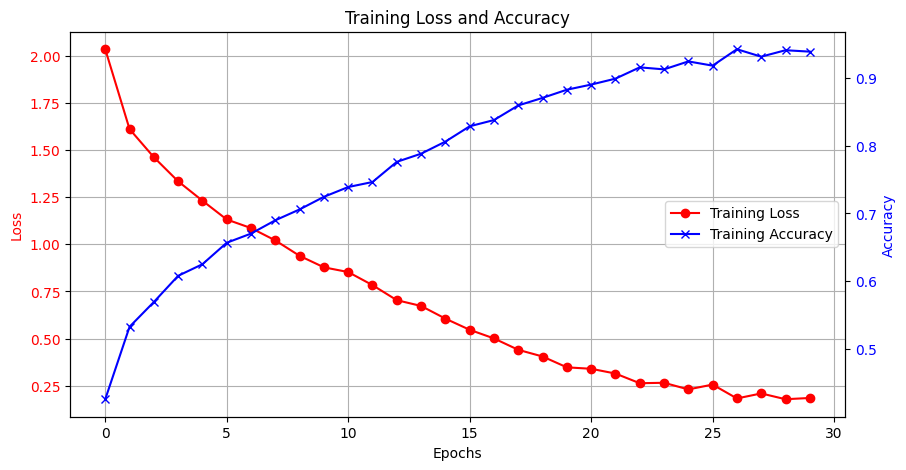

maximum accuracy achieved with 94.22080000000001% at epoch 27


In [ ]:
# Plot losses
import numpy as np
acc = [acc.item() for acc in train_accuracies]
plot_metrics(train_losses, acc)
print(f"maximum accuracy achieved with {round(max(acc), 6) * 100}% at epoch {np.argmax(acc) + 1}")

In [ ]:
import json

data = {
    "train_loss": train_losses,
    "train_accuracy": acc,
    "train_gap": train_gap
}

with open(LOG_FILE, "w") as json_file:
    json.dump(data, json_file, indent=4)


# Test and Eavluation

In [ ]:
def evaluate_model(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0  # Track total samples processed

    with torch.no_grad():
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Evaluating", leave=False)
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            # Update the progress bar with average loss and accuracy
            average_loss = running_loss / total_samples
            average_accuracy = correct_predictions.double() / total_samples
            progress_bar.set_postfix({'avg_loss': f'{average_loss:.4f}', 'avg_acc': f'{average_accuracy:.2f}'})

    total_loss = running_loss / len(dataloader)
    accuracy = correct_predictions.double() / len(dataloader.dataset)
    print(f'Validation Loss: {total_loss}, Accuracy: {accuracy}')
    return total_loss, accuracy  # Optionally return metrics for further analysis


In [ ]:
# Define transformations for the training data
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


label_csv = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/small_data.csv"
test_img_id_to_path_mapping = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/test_img_id_to_path_mapping_drive.csv"
# Create an instance of the dataset
test_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=test_img_id_to_path_mapping
)

# Define the DataLoader
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=2)

model.to(device)
model.load_state_dict(torch.load(MODEL_SAVE_TO))

# Evaluate the model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_fn, device)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 49.60it/s, avg_loss=0.4300, avg_acc=0.67]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                                                                                            

Validation Loss: 1.7178236983142197, Accuracy: 0.6693877551020407
Test Loss: 1.7178236983142197, Test Accuracy: 0.6693877551020407


In [ ]:
# plot_metrics(test_loss, test_accuracy)

# More Experiments

In [ ]:
from tqdm import tqdm
def train_and_evaluate_model(
    model, train_loader, test_loader, loss_fn, optimizer, device, epochs=10, model_save_path="best_model.pth"
):
    model.to(device)
    train_losses = []
    train_accuracies = []
    train_gap = []
    test_accuracies = []
    best_test_accuracy = float("-inf")

    for epoch in range(epochs):
        model.train()
        avg_score = RunningAverage()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Training loop with progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            confs, predicts = torch.max(outputs.detach(), dim=1)
            avg_score.update(GAP(predicts, confs, labels))

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            progress_bar.set_postfix(
                loss=f"{running_loss / total_samples:.4f}",
                acc=f"{(correct_predictions.double() / total_samples * 100):.2f}%",
                gap=f"{avg_score.avg:.4f}"
            )

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_predictions.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        train_gap.append(avg_score.avg)

        # Evaluate on the test dataset
        model.eval()
        correct_predictions_test = 0
        total_samples_test = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct_predictions_test += torch.sum(preds == labels.data)
                total_samples_test += labels.size(0)

        test_acc = correct_predictions_test.double() / total_samples_test
        test_accuracies.append(test_acc)

        # Print epoch results and save the best model if performance improved
        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}, Test Acc: {test_acc:.2f}")

        if test_acc > best_test_accuracy:
            best_test_accuracy = test_acc
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved best model with Test Accuracy: {test_acc:.2f}")

    return train_losses, train_gap, train_accuracies, test_accuracies


In [ ]:
model = initialize_model(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  print("CUDA USED")
else:
  print("CPU USED")

train_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=train_img_id_to_path_mapping,
    # is_pt=True
    is_pt=False
)

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=2)

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


label_csv = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/small_data.csv"
test_img_id_to_path_mapping = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/test_img_id_to_path_mapping_drive.csv"
# Create an instance of the dataset
test_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=test_img_id_to_path_mapping
)
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=2)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CUDA USED


In [ ]:
model.to(device)

train_losses, train_gap, train_accuracies, test_acc_hist = train_and_evaluate_model(model, train_loader, test_loader, loss_fn, optimizer, device, epochs=30, model_save_path=MODEL_SAVE_TO)

Epoch 1/30:   0%|          | 0/421 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/30: 100%|██████████| 421/421 [00:26<00:00, 15.60it/s, acc=44.29%, gap=0.3698, loss=0.1231]


Epoch 1/30: Train Loss: 1.9677, Train Acc: 0.44, Test Acc: 0.47
Saved best model with Test Accuracy: 0.47


Epoch 2/30: 100%|██████████| 421/421 [00:27<00:00, 15.55it/s, acc=52.59%, gap=0.4580, loss=0.1017]


Epoch 2/30: Train Loss: 1.6257, Train Acc: 0.53, Test Acc: 0.55
Saved best model with Test Accuracy: 0.55


Epoch 3/30: 100%|██████████| 421/421 [00:26<00:00, 15.71it/s, acc=57.93%, gap=0.5156, loss=0.0884]


Epoch 3/30: Train Loss: 1.4139, Train Acc: 0.58, Test Acc: 0.56
Saved best model with Test Accuracy: 0.56


Epoch 4/30: 100%|██████████| 421/421 [00:27<00:00, 15.59it/s, acc=60.02%, gap=0.5385, loss=0.0830]


Epoch 4/30: Train Loss: 1.3277, Train Acc: 0.60, Test Acc: 0.60
Saved best model with Test Accuracy: 0.60


Epoch 5/30: 100%|██████████| 421/421 [00:26<00:00, 15.62it/s, acc=63.08%, gap=0.5748, loss=0.0757]


Epoch 5/30: Train Loss: 1.2099, Train Acc: 0.63, Test Acc: 0.62
Saved best model with Test Accuracy: 0.62


Epoch 6/30: 100%|██████████| 421/421 [00:27<00:00, 15.59it/s, acc=65.46%, gap=0.6016, loss=0.0716]


Epoch 6/30: Train Loss: 1.1444, Train Acc: 0.65, Test Acc: 0.64
Saved best model with Test Accuracy: 0.64


Epoch 7/30: 100%|██████████| 421/421 [00:26<00:00, 15.61it/s, acc=67.75%, gap=0.6274, loss=0.0663]


Epoch 7/30: Train Loss: 1.0597, Train Acc: 0.68, Test Acc: 0.61


Epoch 8/30: 100%|██████████| 421/421 [00:27<00:00, 15.40it/s, acc=68.67%, gap=0.6399, loss=0.0633]


Epoch 8/30: Train Loss: 1.0124, Train Acc: 0.69, Test Acc: 0.65
Saved best model with Test Accuracy: 0.65


Epoch 9/30: 100%|██████████| 421/421 [00:27<00:00, 15.48it/s, acc=70.91%, gap=0.6634, loss=0.0587]


Epoch 9/30: Train Loss: 0.9380, Train Acc: 0.71, Test Acc: 0.65
Saved best model with Test Accuracy: 0.65


Epoch 10/30: 100%|██████████| 421/421 [00:27<00:00, 15.54it/s, acc=72.52%, gap=0.6831, loss=0.0554]


Epoch 10/30: Train Loss: 0.8850, Train Acc: 0.73, Test Acc: 0.63


Epoch 11/30: 100%|██████████| 421/421 [00:26<00:00, 15.77it/s, acc=74.71%, gap=0.7077, loss=0.0510]


Epoch 11/30: Train Loss: 0.8147, Train Acc: 0.75, Test Acc: 0.63


Epoch 12/30: 100%|██████████| 421/421 [00:26<00:00, 15.64it/s, acc=76.24%, gap=0.7276, loss=0.0470]


Epoch 12/30: Train Loss: 0.7516, Train Acc: 0.76, Test Acc: 0.70
Saved best model with Test Accuracy: 0.70


Epoch 13/30: 100%|██████████| 421/421 [00:27<00:00, 15.57it/s, acc=78.46%, gap=0.7504, loss=0.0428]


Epoch 13/30: Train Loss: 0.6844, Train Acc: 0.78, Test Acc: 0.67


Epoch 14/30: 100%|██████████| 421/421 [00:26<00:00, 15.60it/s, acc=80.27%, gap=0.7708, loss=0.0385]


Epoch 14/30: Train Loss: 0.6161, Train Acc: 0.80, Test Acc: 0.67


Epoch 15/30: 100%|██████████| 421/421 [00:27<00:00, 15.59it/s, acc=81.82%, gap=0.7886, loss=0.0357]


Epoch 15/30: Train Loss: 0.5714, Train Acc: 0.82, Test Acc: 0.67


Epoch 16/30: 100%|██████████| 421/421 [00:27<00:00, 15.29it/s, acc=83.14%, gap=0.8047, loss=0.0329]


Epoch 16/30: Train Loss: 0.5257, Train Acc: 0.83, Test Acc: 0.68


Epoch 17/30: 100%|██████████| 421/421 [00:27<00:00, 15.44it/s, acc=84.43%, gap=0.8200, loss=0.0302]


Epoch 17/30: Train Loss: 0.4836, Train Acc: 0.84, Test Acc: 0.64


Epoch 18/30: 100%|██████████| 421/421 [00:26<00:00, 15.70it/s, acc=85.66%, gap=0.8345, loss=0.0270]


Epoch 18/30: Train Loss: 0.4314, Train Acc: 0.86, Test Acc: 0.67


Epoch 19/30: 100%|██████████| 421/421 [00:27<00:00, 15.57it/s, acc=87.70%, gap=0.8571, loss=0.0242]


Epoch 19/30: Train Loss: 0.3876, Train Acc: 0.88, Test Acc: 0.69


Epoch 20/30: 100%|██████████| 421/421 [00:26<00:00, 15.65it/s, acc=88.93%, gap=0.8700, loss=0.0218]


Epoch 20/30: Train Loss: 0.3489, Train Acc: 0.89, Test Acc: 0.69


Epoch 21/30: 100%|██████████| 421/421 [00:27<00:00, 15.48it/s, acc=90.27%, gap=0.8874, loss=0.0190]


Epoch 21/30: Train Loss: 0.3046, Train Acc: 0.90, Test Acc: 0.68


Epoch 22/30: 100%|██████████| 421/421 [00:26<00:00, 15.64it/s, acc=90.80%, gap=0.8934, loss=0.0181]


Epoch 22/30: Train Loss: 0.2890, Train Acc: 0.91, Test Acc: 0.72
Saved best model with Test Accuracy: 0.72


Epoch 23/30: 100%|██████████| 421/421 [00:27<00:00, 15.55it/s, acc=90.76%, gap=0.8919, loss=0.0174]


Epoch 23/30: Train Loss: 0.2777, Train Acc: 0.91, Test Acc: 0.68


Epoch 24/30: 100%|██████████| 421/421 [00:26<00:00, 15.66it/s, acc=92.72%, gap=0.9146, loss=0.0139]


Epoch 24/30: Train Loss: 0.2219, Train Acc: 0.93, Test Acc: 0.67


Epoch 25/30: 100%|██████████| 421/421 [00:27<00:00, 15.40it/s, acc=92.59%, gap=0.9142, loss=0.0148]


Epoch 25/30: Train Loss: 0.2363, Train Acc: 0.93, Test Acc: 0.69


Epoch 26/30: 100%|██████████| 421/421 [00:27<00:00, 15.51it/s, acc=93.09%, gap=0.9200, loss=0.0129]


Epoch 26/30: Train Loss: 0.2061, Train Acc: 0.93, Test Acc: 0.70


Epoch 27/30: 100%|██████████| 421/421 [00:26<00:00, 15.74it/s, acc=93.95%, gap=0.9307, loss=0.0121]


Epoch 27/30: Train Loss: 0.1938, Train Acc: 0.94, Test Acc: 0.70


Epoch 28/30: 100%|██████████| 421/421 [00:27<00:00, 15.40it/s, acc=94.00%, gap=0.9301, loss=0.0117]


Epoch 28/30: Train Loss: 0.1873, Train Acc: 0.94, Test Acc: 0.69


Epoch 29/30: 100%|██████████| 421/421 [00:27<00:00, 15.32it/s, acc=93.85%, gap=0.9293, loss=0.0118]


Epoch 29/30: Train Loss: 0.1883, Train Acc: 0.94, Test Acc: 0.67


Epoch 30/30: 100%|██████████| 421/421 [00:27<00:00, 15.56it/s, acc=94.24%, gap=0.9337, loss=0.0109]


Epoch 30/30: Train Loss: 0.1749, Train Acc: 0.94, Test Acc: 0.67


## Plot

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics_acc(train_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 6))

    # Create the first axis for the training loss
    ax1 = plt.gca()  # Get current axis
    line1, = ax1.plot(train_losses, label='Training Loss', color='red', marker='o')
    ax1.set_xlabel('Epochs')  # Common x-axis label
    ax1.set_ylabel('Loss', color='red')  # Set y-axis label for loss
    ax1.tick_params(axis='y', labelcolor='red')  # Set the color of y-axis ticks to red

    # Create a second y-axis for training accuracy using twinx()
    ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
    line2, = ax2.plot(train_accuracies, label='Training Accuracy', color='blue', marker='x')
    ax2.set_ylabel('Accuracy', color='blue')  # Set y-axis label for accuracy
    ax2.tick_params(axis='y', labelcolor='blue')  # Set the color of y-axis ticks to blue

    # Create a third y-axis using a new set of axes positioned to the right
    ax3 = ax1.twinx()  # New axis that shares x-axis
    ax3.spines['right'].set_position(('outward', 60))  # Move the third axis out to avoid overlap
    line3, = ax3.plot(test_accuracies, label='Test Accuracy', color='green', marker='s')
    ax3.set_ylabel('Test Accuracy', color='green')  # Set y-axis label for test accuracy
    ax3.tick_params(axis='y', labelcolor='green')  # Set the color of y-axis ticks to green

    # Title and grid
    plt.title('ResNet-18: Training Loss, Training Accuracy, and Test Accuracy')
    ax1.grid(True)

    # Create legends and position them appropriately
    lines = [line1, line2, line3]
    labels = [l.get_label() for l in lines]
    plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)  # Adjust legend position

    plt.show()


In [ ]:
train_acc = [acc.item() for acc in train_accuracies]
test_acc = [acc.item() for acc in test_acc_hist]
plot_metrics_acc(train_losses, train_acc, test_acc)

NameError: name 'train_accuracies' is not defined

# Save logs

In [ ]:
import json

data = {
    "train_loss": train_losses,
    "train_accuracy": train_acc,
    "train_gap": train_gap,
    "test_accuracy": test_acc
}
LOG_FILE
with open(LOG_FILE, "w") as json_file:
    json.dump(data, json_file, indent=4)
